In [6]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from os import system
from math import floor, log10

## Visualization
from IPython.display import display, clear_output, Pretty

## PFLOTRAN
import jupypft.model as mo
import jupypft.parameter as pm
import jupypft.attachmentRateCFT as arCFT
import jupypft.plotBTC as plotBTC

In [7]:
timePoreVolume = 0.0

def getPV(t):
    return (t * FlowVelocity.value) / (ColumnLenght.value * Porosity.value)  #s

def AssignValues():    
    global timePoreVolume
    timePoreVolume = ColumnLenght.value * Porosity.value / FlowVelocity.value #s
    
    CFL =  1.0
    deltaX = ColumnLenght.value/nZ.value

    #Calculate linked parameters
    ElutionTime.value = InjectTimeInPoreVol * timePoreVolume #s
    whereToStopSimulation = {"Peak":1.0 , "Tail":2.5}
    EndTime.value     = whereToStopSimulation["Peak"] * InjectTimeInPoreVol * timePoreVolume / 3600 #h
    TimeStep.value    = CFL*deltaX*Porosity.value/FlowVelocity.value
    OutTimeStep.value = ElutionTime.value/50.
    
    print("PV -> t = {:.3E} [h]".format(timePoreVolume/3600))

def RunAll():
    system("rm -rf pflotran*")
    
    AssignValues()
    
    #Copy the template as a runFile
    ColumnModel.cloneTemplate()
    
    #Replace the tags in the runFile with values
    for parameter in listOfParameters:
        print(parameter)
        ColumnModel.replaceTagInFile(parameter)
    
    #Run PFLOTRAN
    ColumnModel.runModel()
    
    #Reformat the results file to a CSV
    ColumnModel.fixedToCSV(outputFile="pflotran-obs-0.tec")
    ColumnModel.fixedToCSV(outputFile="pflotran-mas.dat")
    
def ReadResult(file="pflotran-mas.dat",indices = ("Time [h]","Top Vaq [mol/h]")):
    time, conc = plotBTC.get_observationData(file,
                indices = indices,
                normalizeWith = (1.,1.))
    
    return (time,conc)

In [8]:
templateFiles = {"CFT": "tpl_CFT_Bioparticle_Kte.in",
                 "NoFlow"  : "tpl_NoFlow_Bioparticle_Kte.in"}
                
templateFile = "./TEMPLATES/" + templateFiles["CFT"]

ColumnModel = mo.Model(templateFile=templateFile,
                       execPath="$PFLOTRAN_DIR/buildExperimental/pflotran")

In [9]:
Temperature = pm.Real("<referenceTemperature>", value=10.0 , units="C")
ConcentrationAtInlet = pm.Real("<initialConcentration>", value=1.0, units="mol/L")
InjectTimeInPoreVol = 2.0

nX = pm.Integer("<nX>",value=1)
nY = pm.Integer("<nY>",value=1)
nZ = pm.Integer("<nZ>",value=100)

ElutionTime  = pm.Real(tag="<elutionTime>",units="s")
EndTime      = pm.Real(tag="<endTime>", units="d")
TimeStep     = pm.Real(tag="<timeStep>",units="h")
OutTimeStep  = pm.Real(tag="<writeTime>",units="h")

## General
FlowVelocity   = pm.Real(tag="<darcyVel>",units="m/s",mathRep="$$\\vec{q}$$")
ColumnLenght   = pm.Real(tag="<colLenght>",units="m",mathRep="$$L$$")
LongDisp       = pm.Real(tag="<longDisp>",units="m",mathRep="$$\ \alpha_L$$")
Porosity       = pm.Real(tag="<porosity>", units="adim",mathRep="$$\\theta$$")
                               
## Reaction rates
#RateAttachment = pm.Real(tag="<katt>",units="1/s",mathRep="$$k_{att}$$")
RateDetachment = pm.Real(tag="<kdet>",units="1/s",mathRep="$$k_{det}$$")
#decayAqueous   = pm.Real(tag="<decayAq>",units="1/s",mathRep="$$\lambda_{aq}$$")
#decayImmobile  = pm.Real(tag="<decayIm>",units="1/s",mathRep="$$\lambda_{im}$$")

DiameterCollector = pm.Real(tag="<diamCollector>",units="m",mathRep="$$d_{c}$$")
DiameterParticle = pm.Real(tag="<diamCollector>",units="m",mathRep="$$d_{c}$$")
DiameterhamakerConstant = pm.Real(tag="<diamCollector>",units="m",mathRep="$$d_{c}$$")
DiameterCollector = pm.Real(tag="<diamCollector>",units="m",mathRep="$$d_{c}$$")

In [10]:
## General
Porosity.value     = 0.35
FlowVelocity.value = 0.35E-3
ColumnLenght.value = 1.0
LongDisp.value     = 1.0E-4

## Reaction rates
RateAttachment.value = 1.0E-4
RateDetachment.value = 1.0E-4
decayAqueous.value   = 1.0E-5
decayImmobile.value  = 1.0E-3

listOfParameters = pm.Parameter.list_of_vars()

NameError: name 'RateAttachment' is not defined

In [6]:
#RunAll()

PV -> t = 2.778E-01 [h]
<referenceTemperature> = 1.000E+01
<initialConcentration> = 1.000E+00
<nX> = 1
<nY> = 1
<nZ> = 100
<elutionTime> = 2.000E+03
<endTime> = 5.556E-01
<timeStep> = 1.000E+01
<writeTime> = 4.000E+01
$$\vec{q}$$ = 3.500E-04
$$L$$ = 1.000E+00
$$\ lpha_L$$ = 1.000E-04
$$\theta$$ = 3.500E-01
$$k_{att}$$ = 1.000E-04
$$k_{det}$$ = 1.000E-04
$$\lambda_{aq}$$ = 1.000E-05
$$\lambda_{im}$$ = 1.000E-03


In [21]:
ColumnModel.fixedToCSV("pflotran-mas.dat")
#Get results PFLOTRAN
t, Cpflotran = ReadResult(file="pflotran-mas.dat",indices = ("Time [h]","Top Vaq [mol/h]"))
t = t*3600  # Convert to s
Cpflotran = -(Cpflotran/3600.) / (FlowVelocity.value*0.05*0.05*1000) #Convert to concentration

0.6723752412698412


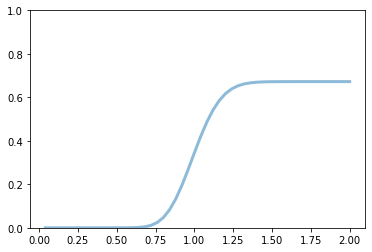

In [22]:
plt.plot(getPV(t),Cpflotran,lw=3,alpha=0.5,zorder=1)
plt.ylim(0,1)
print(max(Cpflotran))

**For a T=50C and $\alpha = 0.5$ ** -> 0.12687450095238093

**For a T=25C and $\alpha = 0.5$ ** -> 0.35876785079365076

**For a T=5C and $\alpha = 0.5$ ** ->0.3782004285714285

In [9]:
mo.Model.list_of_models()

[./pflotran.in -> jupypft.model.Model()]